##### CDT Data Analysis 2022 - Coursework (100%)
# Analysing gravitational wave signals 
## Deadline Jan 27th, 4pm.

#### <div class = "tip">Instructions</div>

Please ensure you have read the information in the **background_info** folder before starting this coursework. 

**These assessments are equivalent to an exam**:
- Submit your work (.ipynb file) via email to the module organiser. Note that you must make sure your notebook compiles fully and that all supporting files that may be included are added to your email.
- Don't worry about how your code looks - marks are not given for pretty code, but rather for the approach used in solving the problem, your reasoning, explanation and answer.
- Please also take note of your University’s policy on **plagiarism**.

#### <div class = "tip">Tips</div>


- Explain all your reasoning for each step. A *significant fraction* of the marks are given for explanations and discussion, as they evidence understanding of the analysis.  
- Some of these steps will take a while to run and compile. It's a good idea to add in print statements to your code throughout eg `print('this step is done')` to make sure that your bit of code has finished.
- Add the import packages statements at the top of your Jupyter notebook. We will use the `pandas` package to read in the data, with eg `dataIn=pd.read_csv('filename.csv')`.

***

Gravitational waves are disturbances in the curvature of spacetime, generated by accelerated masses, that propagate as waves outward from their source at the speed of light.  They are predicted in General Relativity and other theories of gravity and since 2017, they have now been observed!

In this exercise we will analyse some mock gravitational wave data from two unknown astrophysical objects merging together and coelescing. We will use a Monte Carlo Markov Chain (MCMC) to compare a scaled model that predicts how the wave changes depending on the total mass of the merging objects and their distance from us to the observed waveform.  This will allow us to determine the nature of the orbiting objects that merged to form the gravitational wave using MCMC, whether for instance they could be originating from merging white dwarfs, neutron stars or black holes.

The mock or simulated waveforms measure the strain as two compact, dense astrophysical objects coalesce. The strain describes the amplitude of the wave. The system is parameterised by the masses of the merging objects, $M_1$ and $M_2$, and their distance from the observer $D$.  

Other useful parameters and equations relevant for this assessment are given in the background information folder.

***

Installing and loading standard libraries plus some complementary libraries to make widgets work in VScode jupyter notebook

In [1]:
# !pip install pandas
# !pip install matplotlib
# !pip install ipympl

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.widgets import Slider, Button
import ipympl
%matplotlib widget

***

## Part A - The data

1. Read in the datafile of the observed waveform `Observedwaveform.csv`. These files store the strain as a function of "GPS time" for the merger of two bodies. 

2. The GPS time of the merger for your waveform is 1205951542.153363.  Your data will need to be shifted so that the merger occurs at time = 0 secs.  This is required as we will compare our data with a which have the merger at t=0s. 

3. We need to estimate the average noise and its standard deviation in our data. This requires careful thought about where the noise can be seen in the waveform.   

**Answer:**

Loading data using pandas and shifting it so the merger occurs at 0 secs.

In [3]:
data_observed = pd.read_csv('Observedwaveform.csv')
data_observed['time (s)'] = data_observed['time (s)'] - 1205951542.153363

In [4]:
data_observed

,strain,time (s)
0,8.101405e-23,-0.164658
1,1.019082e-22,-0.164169
2,1.226521e-22,-0.163681
3,1.396412e-22,-0.163193
4,1.522380e-22,-0.162705
...,...,...
631,8.309607e-24,0.143448
632,-1.486847e-23,0.143936
633,-2.480454e-23,0.144424
634,-1.817704e-23,0.144913


Let's look at data.

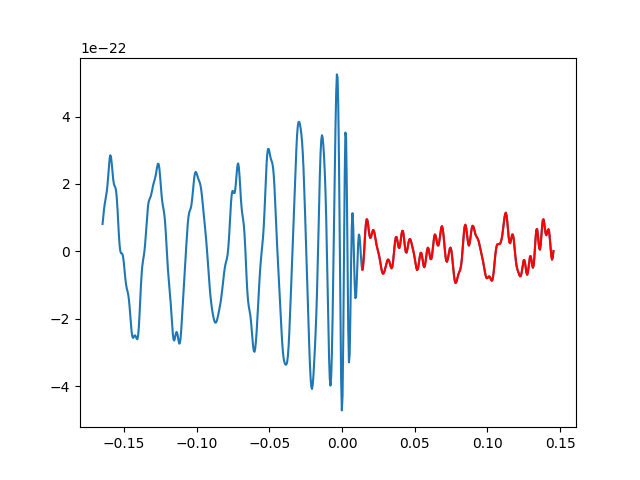

In [5]:
fig1 = plt.figure("Figure 1")
plt.clf()
plt.plot(data_observed['time (s)'], data_observed['strain']);
data_noise = data_observed[data_observed['time (s)'] >= 0.014]
plt.plot(data_noise['time (s)'], data_noise['strain'], c='red')
plt.show();

Will take region where merger signal disappear (approximately at time=0.014?) as region representing noise, so will set time > 0.014s and calculate average and standard deviation.

In [6]:
print ('Average noise: ', data_noise.mean()['strain'])
print ('Standard deviation of noise: ', data_noise.std()['strain'])

Average noise:  3.3088165011894015e-24
Standard deviation of noise:  4.860617158996333e-23


***

## Part B - Using model waveforms to estimate the total mass and distance to the system "a by-eye estimate") 

In this part of the question we will attempt to produce a waveform for any mass and distance values using a reference waveform with $M=40 M_{sun}$, $D=1$ Mpc and $q=M_2/M_1 = 1$ and scaling it by any new mass and/or distance.    

The reference waveform/template we will use is```reference_Mtot40Msun_Dist1Mpc.csv```. 

You will need to follow the steps below when answering this question:

1. Open the reference/template file using the `pandas` package. Write a function in python to scale the time and strain of any waveform with $q=1$, total mass $M$ and distance $D$ from the reference waveform file ```reference_Mtot40Msun_Dist1Mpc.csv``` using the equations for how the waveform strain and time depends on mass and distance from the Background_info_mini_project.ipynb notebook. 

2. Test your function works by substituting in $M=70\,M_{sun}$ and $D=5$Mpc, and compare your resulting waveform with the template in `reference_Mtot70Msun_Dist5Mpc.csv`.  Comment on your result. 
 
3. Use your function to scale the template waveform ($M=40 M_{sun}$, $D=1$Mpc) to make an initial rough estimate "by eye" of the total mass and distance that "best" fits your data (e.g. to within +/- 5 Msun, +/- 100 Mpc). 

**Answer:**

Loading data

In [7]:
ref_template = pd.read_csv('reference_Mtot40Msun_Dist1Mpc.csv')
ref_template

,strain,time (s)
0,-6.162294e-20,-11.946102
1,-6.140841e-20,-11.945614
2,-6.113607e-20,-11.945126
3,-6.080617e-20,-11.944637
4,-6.041902e-20,-11.944149
...,...,...
24617,0.000000e+00,0.073917
24618,0.000000e+00,0.074406
24619,0.000000e+00,0.074894
24620,0.000000e+00,0.075382


Build function which scales reference wave strain and time

In [8]:
def scale_wave(h_ref, t_ref, M, D, M_ref=40, D_ref=1):
    t = t_ref * M / M_ref 
    h = h_ref * (M / M_ref) / (D / D_ref)
    return h, t

Loading data representing event with $M=70\,M_{sun}$ and $D=5$ Mpc to check how function works.

In [9]:
data_check = pd.read_csv('reference_Mtot70Msun_Dist5Mpc.csv')

Checking that function works, for this we will take reference data (with event corresponding to $M=40\,M_{sun}$ and $D=1$ Mpc) and scale them using function above, to check that it works correctly, we also will present data of template with $M=70\,M_{sun}$ and $D=5$ Mpc. Can be seen that function scales data correctly.

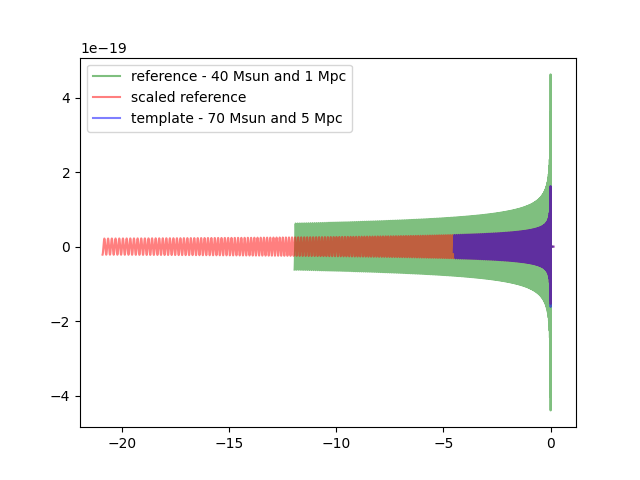

In [10]:
data_scale = ref_template.copy()
data_scale['strain'], data_scale['time (s)'] = scale_wave(ref_template['strain'], ref_template['time (s)'], M=70, D=5)

fig2 = plt.figure("Figure 2")
plt.clf()
plt.plot(ref_template['time (s)'], ref_template['strain'], c='g', alpha=0.5, label='reference - 40 Msun and 1 Mpc')
plt.plot(data_scale['time (s)'], data_scale['strain'], c='r', alpha=0.5, label='scaled reference')
plt.plot(data_check['time (s)'], data_check['strain'], c='b', alpha=0.5, label='template - 70 Msun and 5 Mpc')
plt.legend()
plt.show()

To get initial values for MCMC by eye create graph with widgets to check how wave scales with distance and mass and will try to find a good match.

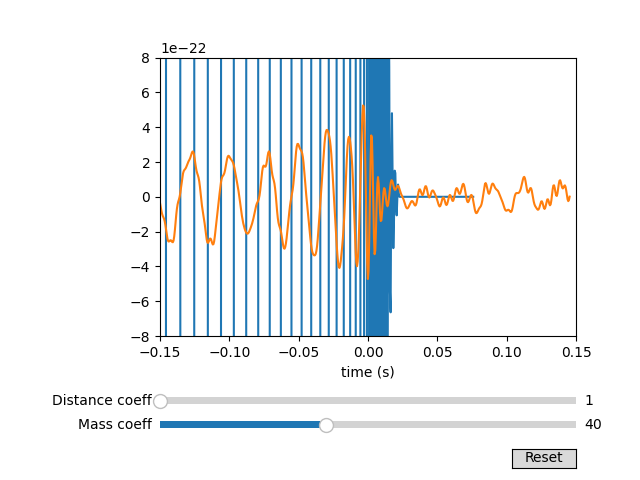

In [11]:
# Define initial parameters
init_M = 40
init_D = 1

h_init, t_init = scale_wave(ref_template['strain'], ref_template['time (s)'], M=init_M, D=init_D)

# Create the figure and the line that we will manipulate
fig, ax = plt.subplots()
line, = ax.plot(t_init, h_init)
ax.set_xlabel('time (s)')
ax.set_xlim(-0.15, 0.15)
ax.set_ylim(-8e-22, 8e-22)
ax.plot(data_observed['time (s)'], data_observed['strain'])

# adjust the main plot to make room for the sliders
fig.subplots_adjust(left=0.25, bottom=0.3)

# Make a horizontal slider to control distance
axD = fig.add_axes([0.25, 0.15, 0.65, 0.03])
D_slider = Slider(
    ax=axD,
    label='Distance coeff',
    valmin=0.1,
    valmax=10000,
    valinit=init_D,
)

# Make a horizontal slider to control mass
axM = fig.add_axes([0.25, 0.1, 0.65, 0.03])
M_slider = Slider(
    ax=axM,
    label='Mass coeff',
    valmin=0.001,
    valmax=100,
    valinit=init_M,
)

# The function to be called anytime a slider's value changes
def update(val):
    h, t = scale_wave(ref_template['strain'], ref_template['time (s)'], M=M_slider.val, D=D_slider.val)
    line.set_xdata(t)
    line.set_ydata(h)
    fig.canvas.draw_idle()


# register the update function with each slider
D_slider.on_changed(update)
M_slider.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')


def reset(event):
    M_slider.reset()
    D_slider.reset()
button.on_clicked(reset)

plt.show()
plt.plot();

Good match with values approximately D_init = 1707 and M_init = 77.92 (and this sounds correct as it was mentioned on coursework session that distance should be very big), let's plot it separately.

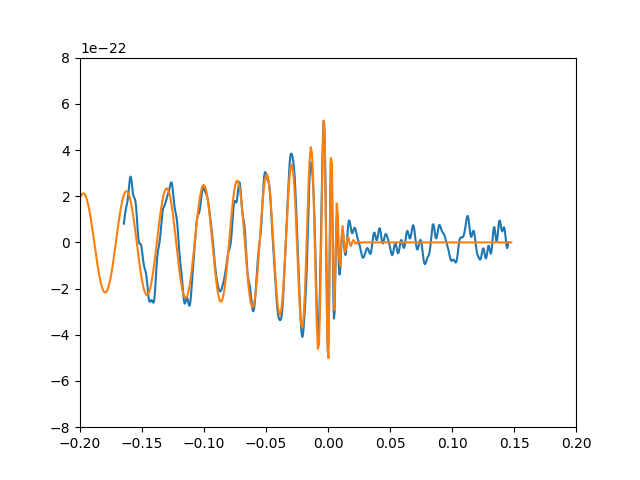

Approximate values of mass and distance are: 
M = 77.92 Msun 
D = 1707 Mpc


In [12]:
fig3 = plt.figure("Figure 3")
plt.clf()
M_init = 77.92
D_init = 1707

h, t = scale_wave(ref_template['strain'], ref_template['time (s)'], M=M_init, D=D_init)

plt.plot(data_observed['time (s)'], data_observed['strain'])
plt.xlim(-0.20, 0.20)
plt.ylim(-8e-22, 8e-22)
plt.plot(t, h)
plt.show();


print(
    'Approximate values of mass and distance are: \n'
    f'M = {M_init} Msun \n'
    f'D = {D_init} Mpc'
)

***

## Part C- Get data and model to have the same x values. 

Now that we have our observed data, and can scale the template data to any mass and distance, we need to do one more fix.  Currently our data and our templates have different sampling on the $x$ axis - ie they have different values of $x$ (time(.  We need to try and match the $x$ times up so that for each value of $x$ we can compare the $y$ values (the observed strain with the strain from the scaled template).  

We need to only consider the times when we have observed data, so we will trim our data set.

1.  Our data waveform starts at some time $t_{\rm min}$. Find out what this is.  Next, take your observed data waveform and output data for $t$ > $t_{\rm min}$ and $t$ < $0$ (ie only keep information for times $\le 0$ (before the merger), or for times where there is data).  Verify, by plotting, that your new observed waveform only has data in this restricted time range. 

2. We now need to put both observed and template waveforms on the same time sampling, ie the same number of data points.  The model waveforms have approx 20,000+ time steps, yet the data has less than hundreds in the time range specified!  

We need to interpolate between our observed data and the template. To do this use the following code:

(assuming `x[index]` and `y[index]` are the observed data from Part D.1 and scaled template time is your scaled reference template to your suggested values of $M$ and $D$ from Part C3.)

```
from scipy.interpolate import interp1d

# get interpolation object using data
interp_fn =interp1d(x[index],y[index],bounds_error=False)

# now get scaled template and get the strains for the same x axis as data
interp_strain = interp_fn(scaled_template_time)

#plot
plt.plot(scaled_template_time,interp_strain)
```

Briefly verify that this works. 

*Hints:*
 * *One can use the following code example  `index = np.where((data > 5)&(data < 10))[0]`. This type of statement returns a list of indices (`index`) where the conditions in the bracket have been met.  `data_[index]` pulls out `data` that satisfy the conditions in the brackets above.*

**Answer**

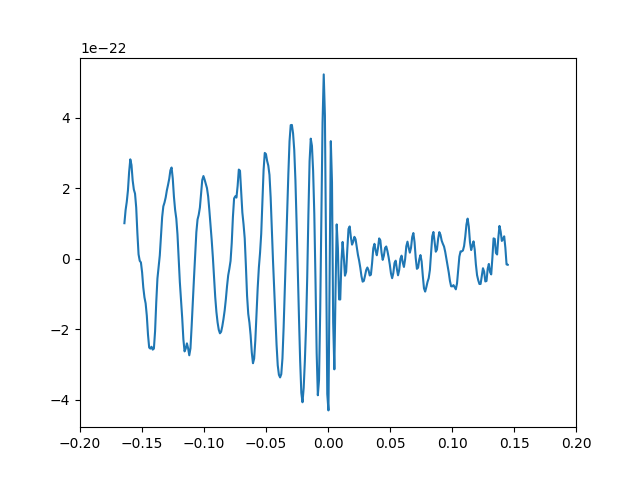

In [13]:
from scipy.interpolate import interp1d

index = np.where((ref_template['time (s)'] >= data_observed['time (s)'].min())& \
                 (ref_template['time (s)'] <= data_observed['time (s)'].max()))[0]

ref_template = ref_template.loc[index].reset_index(drop=True)

scaled_template_strain, scaled_template_time = scale_wave(ref_template['strain'], ref_template['time (s)'], M=M_init, D=D_init)

# get interpolation object using data
interp_fn =interp1d(data_observed['time (s)'], data_observed['strain'], bounds_error=False)

# now get scaled template and get the strains for the same x axis as data
interp_strain = interp_fn(scaled_template_time)

#plot
fig4 = plt.figure("Figure 4")
plt.clf()
plt.plot(scaled_template_time, interp_strain)
plt.xlim(-0.20, 0.20)
plt.show();

***

## Part D - Estimating the best fit total mass using MCMC 

Now that we know how to make the scaled template (ie 40Msun,1Mpc template file) and the observed data have the same time sampling, we can use MCMC to find out the total mass of the system that made the data we see.  

*If you run into any difficulties completing this component of the coursework, you can still attempt the following parts using your by-eye estimates for $M$ and $D$ from Part B.*

Think carefully about what the likelihood function will be in this case (see Chapters 6-9).  

1. Use MCMC to sample the total mass $M$ to produce a best-fit value for your data. 

2.  Display the results in an appropriate manner and comment on your findings, as well as your results from the MCMC. 

3. Report the median and 90% credible limits on your values.  
 
You may assume that:
- the noise is described by a Gaussian distribution, 
- the total mass of the system is in the range [20,100] $M_{sun}$.
 
_Hints:_

 * _Think very carefully about the form of your likelihood since here we are comparing observed data with a model_
 
 * _You should work with "log(Likelihood)" to avoid numerical errors  - note this will affect both your posterior and the step in the MCMC chain where we usually write_ $p_{\rm proposed}/p_{\rm current}$

 * _The step size between samples of the MCMC is quite important. A suggested value for the mass is_ $0.1\,M_{sun}$
 
 * _The initial guess of your mass is also very important. You may find yourself getting into a local minimum rather than your code finding the true minimum._
 
 * _Test your MCMC on a small number of samples (e.g. 10-100) before trying it with a larger number_ (e.g. $10^5$ or $10^6$)
 
 * _At the end, ask yourself if you need to include every sample?_
 
 * _Depending on your step size, this part can take a long time to run. Suggest that you move all your plotting routines to a different code cell to save you re-running everything 10000s of times when you just want to change a plot command._
 
 * _To find out how long it will take for a Jupyter notebook to compile the MCMC code cell, add the following snippet to your code before you go into your MCMC loop (where Nsteps is the number of steps your MCMC is using):_
 
```
def time_spent_waiting(n):
from datetime import datetime,timedelta
preddur=[n*0.01,n*0.02]
print('predicted duration: {:.2f}-{:.2f} mins'.format(preddur[0]/60.,preddur[1]/60.))
return
```

**Answer:**

In [14]:
from scipy.stats import norm
%matplotlib inline

std_noise=data_noise.std()['strain']

def log_likelihood(M_current_i, y_data=data_observed['strain'], std_noise=std_noise):
    h_model, scaled_template_time = scale_wave(
        ref_template['strain'],
        ref_template['time (s)'],
        M=M_current_i, D=D_init)
    
    # now get scaled template and get the strains for the same x axis as data
    interp_fn =interp1d(data_observed['time (s)'], data_observed['strain'], bounds_error=False)

    # now get scaled template and get the strains for the same x axis as data
    interp_strain = interp_fn(scaled_template_time)

    return -0.5 * np.sum(((interp_strain - h_model) / std_noise) **2)

# set up MCMC step paramaters
N_mcmc = 10000
M_current = np.zeros(N_mcmc+1)
# use our prior as a guess
M_current[0] = M_init


for i in range(N_mcmc):
    p_current = log_likelihood(M_current[i]) # put current value in posterior equation
    dM = np.random.normal(0, 1) # randomally draw a value of theta to trial 
    M_proposed = M_current[i] + dM #get new proposed theta (random theta + stepsize)
    p_proposed = log_likelihood(M_proposed) # calculate posterior p for proposed theta
    
    #  keep this value if probability proposed theta greater than the current prob
    if p_proposed > p_current: 
        M_current[i+1] = M_proposed
    else:
    # if probability lower
    # use the ratios of probability to define probability of whether we move to that value or not
        p_new_move = np.exp(p_proposed - p_current)
        # generate random number for probability
        u_random = np.random.uniform(0,1)
        # if u_random < p_new_move, then accept, if not, reject
        if u_random <= p_new_move:
            M_current[i+1] = M_proposed
        else:
            M_current[i+1] = M_current[i]

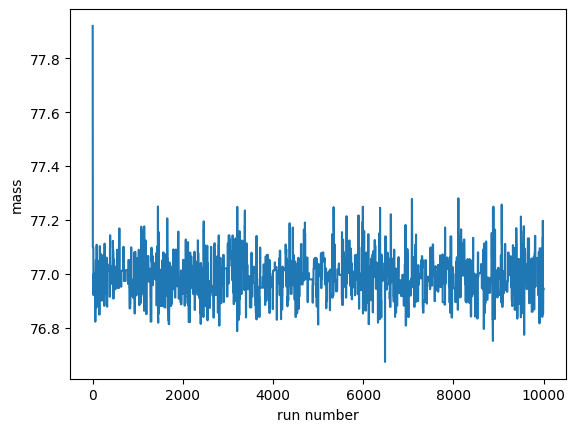

In [18]:
fig5 = plt.figure("Figure 5")
plt.clf()
plt.plot(M_current)
plt.xlabel('run number')
plt.ylabel('mass')
plt.show();

In [18]:
# get mean + std from mcmc generated samples
mean_mcmc=np.mean(M_current[5:])
std_mcmc=np.std(M_current[5:])

print('The mean total mass from the MCMC is {:.2f} +/- {:.2f} Msun'.format(mean_mcmc,std_mcmc))

The mean total mass from the MCMC is 77.00 +/- 0.08 Msun


***

## Part E - Putting it all together 

If you run into any difficulties completing Part E, you can still attempt this part using your by-eye estimates for $M$ and $D$ from Part B.

1. Calculate the chirp mass for your system and the individual masses of your merging bodies. Comment on your individual masses. 

2. Comment on what your analysis suggests are the best astrophysical candidates for the merging objects?  What information are you missing to rule out other astrophysical candidates?

**Answer:**

So big total mass as 77 Msun suggests that it is more likely a binary black hole merger. Also in background info for making calculations for scaling we assumed mass ration q=1, so I will take $M_1 = M_2 = M_{total}/2$ to calculate chirp mass.

In [19]:
M1 = M2 = mean_mcmc / 2
M_chirp = (M1 * M2)**(3/5) / (M1 + M2)**(1/5)
print('Chirp mass = {:.2f} \nIndividual masses M1 and M2 = {:.2f}'.format(M_chirp, M1))

Chirp mass = 33.51 
Individual masses M1 and M2 = 38.50


*Your answer here*



***